In [19]:
import os
import csv
import pandas as pd

notebook_path = os.path.abspath("MACD_indicator.ipynb")

df = pd.read_csv('wig20_d.csv', usecols=['Data', 'Otwarcie'])

#for index, row in df.iterrows():
#    print(row['Otwarcie'])
#print(df)

In [23]:
# zainstalowac i przetestowac jak dziala altair
import altair as alt
alt.Chart(data=df).mark_point().encode(
    x="sepal_width",
    y="sepal_length",
    color="species",
    size='sepal_length'
)

ModuleNotFoundError: No module named 'altair'

<AxesSubplot:>

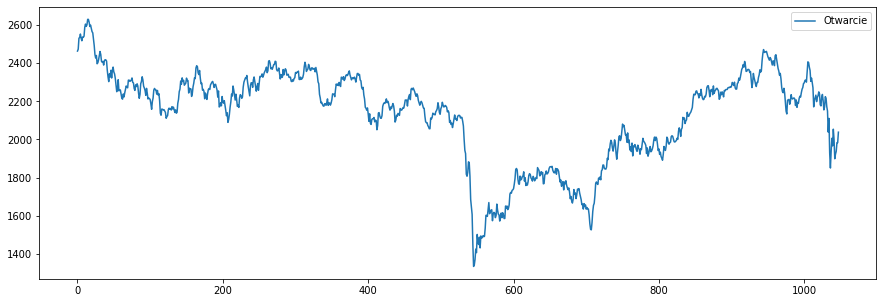

In [22]:

import matplotlib.pylab as plt
from datetime import datetime
# changing the plot size
plt.rcParams['figure.figsize'] = [15, 5]

notebook_path = os.path.abspath("MACD_indicator.ipynb")
data_csv = os.path.join(os.path.dirname(notebook_path), "wig20_d.csv")

df.plot()

In [16]:
data = {}
with open(data_csv, mode="r") as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            #if line_count == 0:
                #print(f'Column names are {", ".join(row)}')
            #    line_count += 1
            #print(f'{row["Data"]} : {row["Otwarcie"]}')
            # date format : 2018-01-03
            date = datetime.strptime(row["Data"], '%Y-%m-%d')
            data[date] = float(row["Otwarcie"])
            line_count += 1
#print (data)       

# showing loaded data

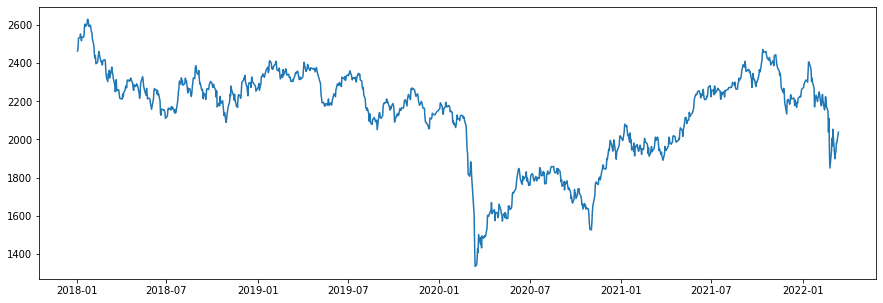

In [21]:

lists = sorted(data.items())
x, y = zip(*lists)
plt.plot(x,y)
plt.show()